# 02. 분류

In [16]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## 2-1. 로지스틱 회귀
### 이진 분류

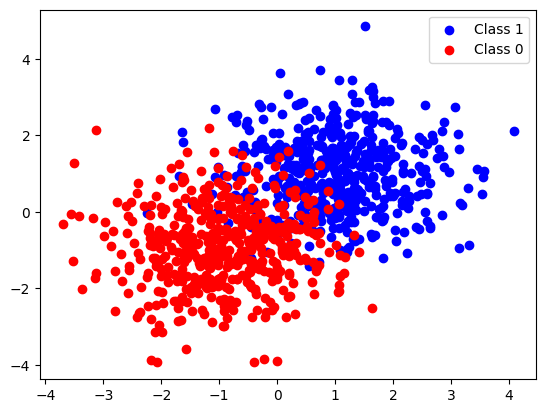

Epoch [100 / 1500], Loss:  0.6132
Epoch [200 / 1500], Loss:  0.4128
Epoch [300 / 1500], Loss:  0.3348
Epoch [400 / 1500], Loss:  0.2949
Epoch [500 / 1500], Loss:  0.2710
Epoch [600 / 1500], Loss:  0.2550
Epoch [700 / 1500], Loss:  0.2437
Epoch [800 / 1500], Loss:  0.2353
Epoch [900 / 1500], Loss:  0.2288
Epoch [1000 / 1500], Loss:  0.2237
Epoch [1100 / 1500], Loss:  0.2195
Epoch [1200 / 1500], Loss:  0.2161
Epoch [1300 / 1500], Loss:  0.2132
Epoch [1400 / 1500], Loss:  0.2108
Epoch [1500 / 1500], Loss:  0.2087


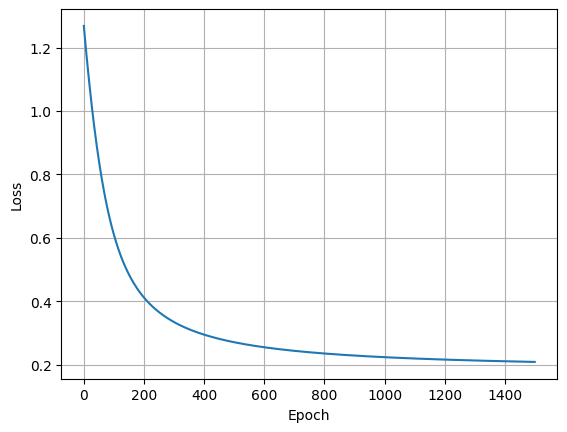

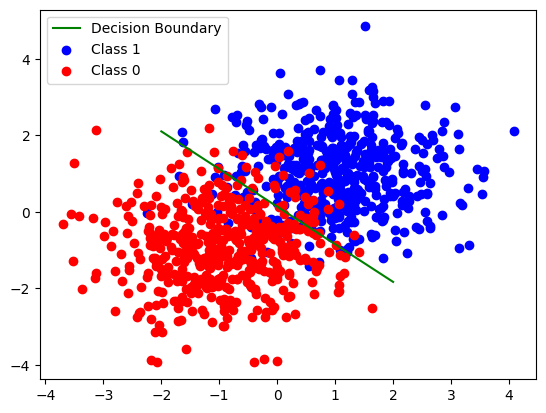

In [10]:
# 1. 데이터 입출력 정의
np.random.seed(42) # 시드 고정
num_samples = 1000

# 가우시안 샘플 생성
# 평균이 (1,1)인 2D 정규분포
mean_1 = np.array([1., 1.])
cov_1 = np.array([[1,0], [0,1]])
data_1 = np.random.multivariate_normal(mean_1, cov_1, num_samples // 2)

mean_2 = np.array([-1., -1.])
cov_2 = np.array([[1,0], [0,1]])
data_2 = np.random.multivariate_normal(mean_2, cov_2, num_samples // 2)

# 데이터 확인
plt.scatter(data_1[:, 0], data_1[:, 1], color="b", label="Class 1")
plt.scatter(data_2[:, 0], data_2[:, 1], color="r", label="Class 0")
plt.legend()
plt.show()

# 데이터 정의 및 텐서로 저노한
data = np.vstack((data_1, data_2))
labels = np.ones(num_samples)
labels[num_samples//2: ] = 0

data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()
labels = labels.view(-1, 1)
num_samples, num_features = data.shape

# 모델 정의
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
    
model = LogisticRegression(2, 1)

# 3. 손실함수 정의
criterion = nn.BCELoss()

# 4. 가중치 업데이트 (학습)
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
epochs = 1500
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1} / {epochs}], Loss: {loss.item(): .4f}")

# 5. 시각화
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# 걸정 경게 그리기
w = model.linear.weight.detach().cpu().numpy()
b = model.linear.bias.detach().cpu().numpy()
x_plot = np.array([-2, 2])
y_plot = np.array(-b -w[0][0] * x_plot) / w[0][1]
plt.plot(x_plot, y_plot, color="g", label="Decision Boundary")
plt.scatter(data_1[:, 0], data_1[:, 1], color="b", label="Class 1")
plt.scatter(data_2[:, 0], data_2[:, 1], color="r", label="Class 0")
plt.legend()
plt.show()

## 2-2. FashionMNINT 신경망 (다항분류)

In [ ]:
# 1. 데이터 입출력 정의
transform = transforms.ToTensor() # 이미지 데이터를 tensor로 변환

# 트레이닝 데이터 정의
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# 데이터 로더 정의
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 2. 모델 정의
class MultiClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # 깊어질수록 특징을 요약/압축의 목적
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512), # 정규화
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10) # 각 클래스 정수 10개를 출력
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.model(x)
        return out

# instantiate model and training utilities at top level (not inside the class)
model = MultiClassificationModel()

# 3. 손실함수 정의
criterion = nn.CrossEntropyLoss()

# 4. 가중치 업데이트 (학습)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# 학습 루프
def train_loop(dataloader, model, criterion, optimizer):
    model.train() # 학습 모드
    size = len(dataloader.dataset)
    running_loss = 0.

    # x는 데이터, y는 정답
    for batch, (x,y) in enumerate(dataloader):
        optimizer.zero_grad() # 초기화
        outputs = model(x) # 순전파
        loss = criterion(outputs, y) # 손실 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item() * x.size(0) # loss에 batch size를 곱

        if (batch + 1) % 100 == 0:
            current = batch * len(x)
            print(f"[batch: {batch+1 :4d}, Loss: {loss.item() :>7f} ({current :>5d}/{size:5d})]")

    epoch_loss = running_loss / size
    return epoch_loss

# 테스트 루프
def test_loop(dataloader, model, criterion):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0.
    correct = 0

    with torch.no_grad():
        for x, y in dataloader:
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
    
    avg_loss = test_loss / num_batches
    accuracy = correct / size
    print(f"test - Accuracy: {100 * accuracy:5.1f}%, Avg_loss: {avg_loss:>8f}")
    return avg_loss, accuracy

# 학습 실행
print()
for epoch in range(epochs):
    print(f"[Epoch] {epoch+1}/{epochs}")
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    val_loss, val_acc = test_loop(test_dataloader, model, criterion)

print()
print("완료")

# 5. 시각화
label_tags = {
    0: "T-shirt", 1: "Trouser", 2: "pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}

rows, columns = 6, 6
fig = plt.figure(figsize=(15, 15))
model.eval()

for i in range(1, rows * columns + 1):
    data_idx = np.random.randint(len(test_data))
    img_tensor, true_label = test_data[data_idx]

    with torch.no_grad():
        x = img_tensor.unsqueeze(0)
        output = model(x)
        pred_idx = output.argmax(1).item()

    pred_class = label_tags[pred_idx] # 예측한 태그
    true_class = label_tags[true_label] # 정답 태그

    is_correct = pred_idx == int(true_label)
    title = f"{pred_class}, correct" if is_correct else f"{pred_class}, incorrexct! answer: {true_class}"
    cmap = "Blues" if is_correct else "Reds"

    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(img_tensor.squeeze(0).numpy(), cmap=cmap)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


[Epoch] 1/10
[batch:  100, Loss: 0.625161 ( 6336/60000)]
[batch:  200, Loss: 0.341363 (12736/60000)]
[batch:  300, Loss: 0.574830 (19136/60000)]
